Block size:(2,2), Time processing on GPU: 0.11862850189208984s
Block size:(4,4), Time processing on GPU: 0.00019407272338867188s
Block size:(8,8), Time processing on GPU: 0.00013589859008789062s
Block size:(16,16), Time processing on GPU: 0.00014066696166992188s
Block size:(32,32), Time processing on GPU: 0.000125885009765625s
Block size:(32,22), Time processing on GPU: 0.0001246929168701172s


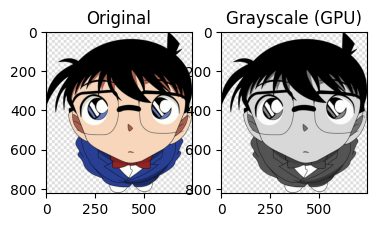

In [20]:
import numba
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from numba import jit
from matplotlib.image import imread
import time

# Load an image from a file
image_path = 'labwork3-original.jpg'
image = imread(image_path)
plt.subplot(131), plt.imshow(image), plt.title('Original')

# Get the image dimensions
image_height = image.shape[0]
image_width = image.shape[1]

# grayscale using GPU with 2D blocks
@cuda.jit
def grayscale_gpu(src, dst):
    x = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    y = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
    g = np.uint8((src[x, y, 0] + src[x, y, 1] + src[x, y, 2]) // 3)
    dst[x, y, 0] = dst[x, y, 1] = dst[x, y, 2] = g

#Implement with GPU
blockSizes = [(2,2),(4,4),(8, 8),(16, 16),(32,32),(32,22)]
times_gpu = []

for block_size in blockSizes:
  devSrc = cuda.to_device(image)
  devDst = cuda.device_array((image_height, image_width, 3), np.uint8)

  grid_size_x = (image_height + block_size[0] - 1) // block_size[0]
  grid_size_y = (image_width + block_size[1] - 1) // block_size[1]
  start_time_gpu = time.time()
  grayscale_gpu[(grid_size_x, grid_size_y), block_size](devSrc, devDst)
  time_gpu = time.time() - start_time_gpu
  times_gpu.append(time_gpu)
  print(f"Block size:({block_size[0]},{block_size[1]}), Time processing on GPU: {time_gpu}s")

  hostDst = devDst.copy_to_host()
  grayscale_gpu_image = np.array(hostDst)
  plt.imsave('labwork4-grayscale_gpu.jpg', grayscale_gpu_image, cmap='gray')
  plt.subplot(132), plt.imshow(grayscale_gpu_image, cmap='gray'), plt.title('Grayscale (GPU)')

plt.show()